# Proyecto de Cátedra – Machine Learning Supervisado
## Predicción de deserción temprana al finalizar el primer año académico (Clasificación)

**Dataset:** `Tbl_DesercionEstudiantil.csv`

## 1. Introducción y descripción del problema

### Contexto
Una Institucion educativa busca **identificar estudiantes con riesgo de deserción** para intervenir a tiempo (acompañamiento académico, becas, tutorías, etc.).

### Problema
- **Tipo:** Clasificación supervisada
- **Variable objetivo:** `Deserto` (1 = desertó, 0 = no desertó)
- **Objetivo:** Estimar la probabilidad de deserción en el próximo ciclo/periodo con base en variables académicas y administrativas.

### Valor para la organización
- Priorizar acciones de retención (contacto, apoyo financiero, tutorías).
- Reducir costos asociados a la pérdida de estudiantes.
- Monitorear indicadores de riesgo por carrera/campus/periodo.

### Supuestos importantes
- Este dataset contiene registros por estudiante/ciclo (no necesariamente un único registro por estudiante).

## 2. Carga y exploración inicial de datos

In [4]:
# 2.1 Importar librerías
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # ← AGREGADO: útil para visualizaciones más claras
import openpyxl 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,  # ← AGREGADO: métrica clave para deserción
    precision_score,  # ← AGREGADO
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay
)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb  # ← AGREGADO: tu modelo final

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
# Carga del dataset
DATA_PATH = "Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv"
df = pd.read_csv(DATA_PATH)

MAX_SAMPLES = 10000

# Debido a la cantidad de datos, obtenemos el dataset proporcionado 
# en una muestra representativa de 10,000 filas, manteniendo la proporción de cada clase 
# en la columna "Deserto".
if len(df) > MAX_SAMPLES:
    df = df.groupby("Deserto", group_keys=False).apply(
        lambda x: x.sample(
            n=int(MAX_SAMPLES * len(x) / len(df)),
            random_state=42
        )
    )
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (9459, 25)


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,Deserto
0,219,2013,1,102302.0,2015,1,300,0,NaN,3,3,0,1.0,7.54,3,3,0,1.00,7.02,6,6,0,1.0000,7.28,0
1,209,2014,1,102301.0,2015,1,152,0,NaN,5,4,1,0.8,6.56,5,3,2,0.60,5.56,10,7,3,0.7000,6.06,0
2,702,2014,1,102301.0,2015,1,264,0,NaN,5,5,0,1.0,7.01,4,3,0,0.75,6.18,9,8,0,0.8889,6.59,0
3,702,2014,1,102301.0,2015,1,485,0,NaN,5,2,2,0.4,4.73,4,2,1,0.50,6.28,9,4,3,0.4444,5.50,0
4,106,2009,1,102301.0,2015,1,241,0,NaN,5,1,4,0.2,4.40,2,2,0,1.00,7.20,7,3,4,0.4286,5.80,0


In [6]:
len(df)


9459

In [7]:
# Tipos de datos y resumen general
df.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9459 entries, 0 to 9458
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Carrera                        9459 non-null   int64  
 1   Plan                           9459 non-null   int64  
 2   IdCampus                       9459 non-null   int64  
 3   Sexo                           9458 non-null   float64
 4   AnioIngreso                    9459 non-null   int64  
 5   CicloIngreso                   9459 non-null   int64  
 6   InstitucionBach                9459 non-null   int64  
 7   TieneBeca                      9459 non-null   int64  
 8   PorcentajeBeca_Promedio        598 non-null    float64
 9   MateriasInscritas_C1           9459 non-null   int64  
 10  MateriasAprobadas_C1           9459 non-null   int64  
 11  MateriasReprobadas_C1          9459 non-null   int64  
 12  TasaAprobacion_C1              9459 non-null   f

In [8]:
# Duplicados y nulos

# Normaliza nombres de columnas (quita espacios extremos)
df.columns = [str(c).strip() for c in df.columns]

# Eliminar duplicados
df_before = df.shape[0]
df = df.drop_duplicates()
df_after = df.shape[0]
print(f"[LIMPIEZA] Duplicados eliminados: {df_before - df_after}")

# Limpieza de strings en columnas tipo object
obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Reemplazo de strings "vacíos" por NaN (para imputación correcta)
df.replace({"": np.nan, "NA": np.nan, "N/A": np.nan, "null": np.nan, "None": np.nan}, inplace=True)



[LIMPIEZA] Duplicados eliminados: 0


### Definición rápida de variable objetivo

Validamos que `Deserto` sea binaria y revisamos el balance de clases.

In [9]:
target_col = "Deserto"

print("Valores únicos en Deserto:", sorted(df[target_col].dropna().unique()))
df[target_col].value_counts(dropna=False)


Valores únicos en Deserto: [0, 1]


Deserto
0    8350
1    1109
Name: count, dtype: int64

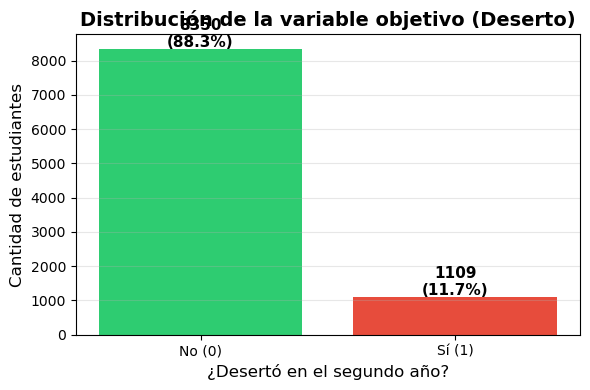


 Proporciones de clase:
Deserto
0    0.8828
1    0.1172
Name: count, dtype: float64


In [10]:
# Distribución (balance) de clases
counts = df[target_col].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values, color=['#2ecc71', '#e74c3c'])
plt.title("Distribución de la variable objetivo (Deserto)", fontsize=14, fontweight='bold')
plt.xlabel("¿Desertó en el segundo año?", fontsize=12)
plt.ylabel("Cantidad de estudiantes", fontsize=12)
plt.xticks(ticks=range(len(counts)), labels=['No (0)', 'Sí (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)

# Agregar etiquetas con porcentajes
for i, (idx, val) in enumerate(counts.items()):
    pct = 100 * val / counts.sum()
    plt.text(i, val + 50, f'{val}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Proporciones de clase:")
proportions = (counts / counts.sum()).round(4)
print(proportions)


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Preparación: identificar variables numéricas y categóricas

Como el dataset contiene **códigos** (por ejemplo `Carrera`, `Plan`, `InstitucionBach`), se separan columnas en:
- **Numéricas continuas / de conteo** (útiles para histogramas y correlación).
- **Categóricas codificadas** (útiles para conteos por categoría).


In [11]:

# 2.7 Identificación de variables categóricas y numéricas

print("IDENTIFICACIÓN DE TIPOS DE VARIABLES")

# Heurística: columnas con baja cardinalidad suelen comportarse como categóricas (aunque sean int)
nunique = df.nunique()
low_cardinality_cols = nunique[nunique <= 30].index.tolist()

# Objetivo no se considera feature
if target_col in low_cardinality_cols:
    low_cardinality_cols.remove(target_col)

# Candidate categóricas: baja cardinalidad + tipo int/obj
categorical_cols = [c for c in low_cardinality_cols if df[c].dtype == 'object' or df[c].dtype == 'int64']

# Agregamos estas categorías por si son detectadas como numéricas
forced_categorical = ["InstitucionBach", "Carrera", "Plan", "IdCampus", "Sexo"]

for col in forced_categorical:
    if col in df.columns and col not in categorical_cols:
        categorical_cols.append(col)

# Candidate numéricas: el resto (incluye float, conteos con alta cardinalidad)
numeric_cols = [c for c in df.columns if c not in categorical_cols + [target_col]]

print(f"\n Columnas categóricas detectadas ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\n Columnas numéricas detectadas ({len(numeric_cols)}):")
print(numeric_cols)

IDENTIFICACIÓN DE TIPOS DE VARIABLES

 Columnas categóricas detectadas (17):
['Plan', 'IdCampus', 'AnioIngreso', 'CicloIngreso', 'TieneBeca', 'MateriasInscritas_C1', 'MateriasAprobadas_C1', 'MateriasReprobadas_C1', 'MateriasInscritas_C2', 'MateriasAprobadas_C2', 'MateriasReprobadas_C2', 'TotalMateriasInscritas_Anio1', 'TotalMateriasAprobadas_Anio1', 'TotalMateriasReprobadas_Anio1', 'InstitucionBach', 'Carrera', 'Sexo']

 Columnas numéricas detectadas (7):
['PorcentajeBeca_Promedio', 'TasaAprobacion_C1', 'PromedioCiclo_C1', 'TasaAprobacion_C2', 'PromedioCiclo_C2', 'TasaAprobacion_Anio1', 'PromedioGeneral_Anio1']


### 3.2 Análisis univariado

- Distribuciones de variables numéricas (histogramas).
- Outliers con boxplots (muestra rápida).
- Conteos para variables categóricas.


ANÁLISIS DE VARIABLES NUMÉRICAS


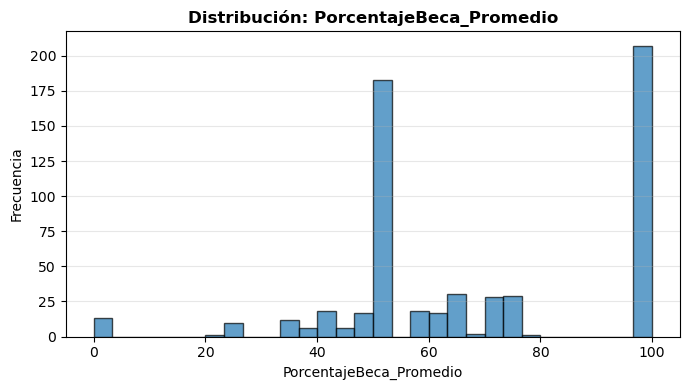

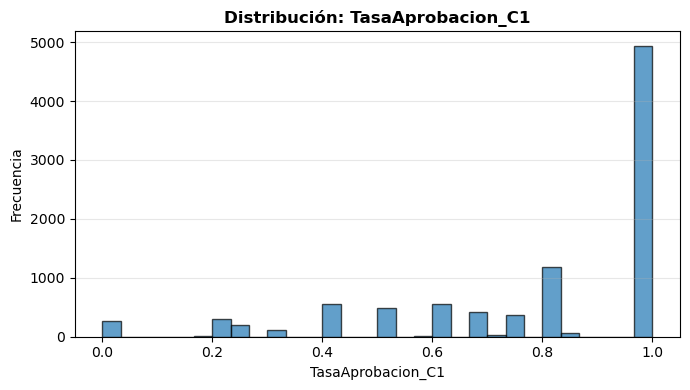

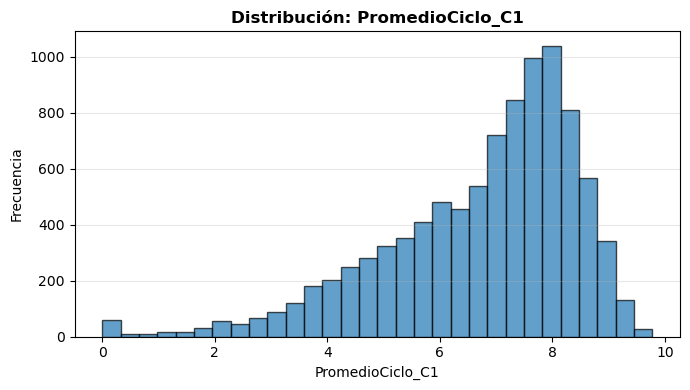

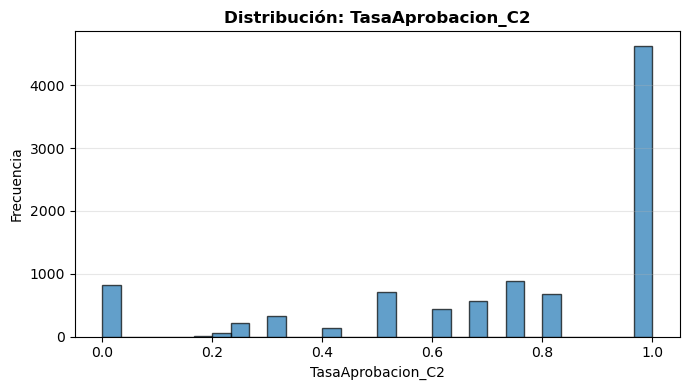

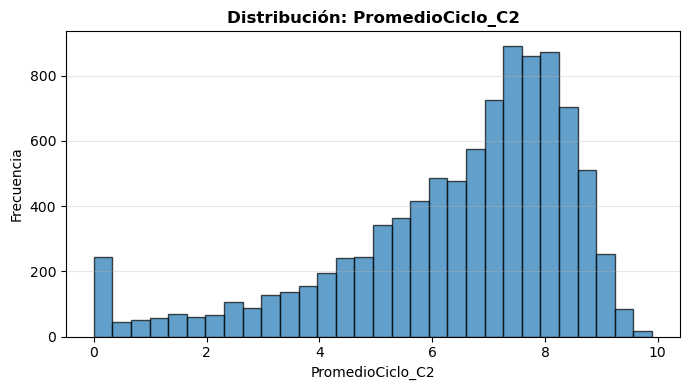

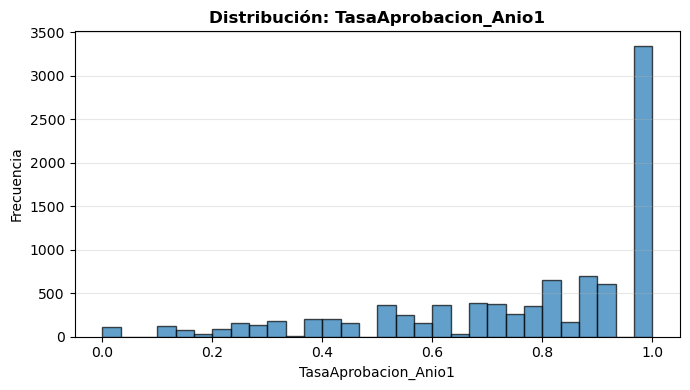

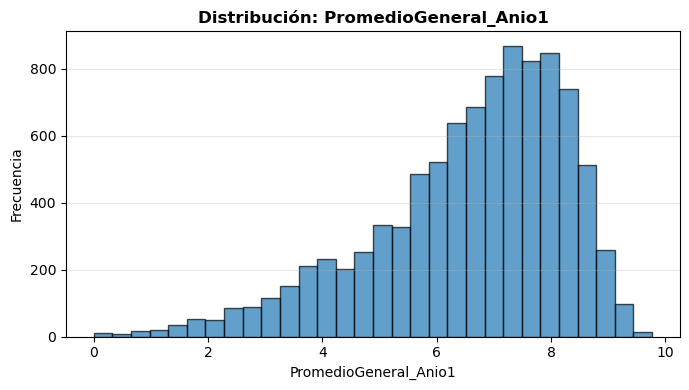

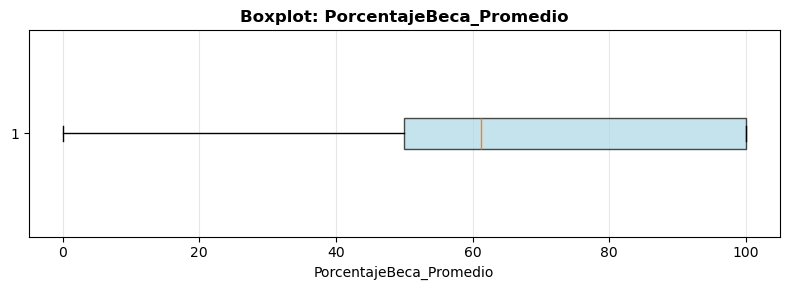

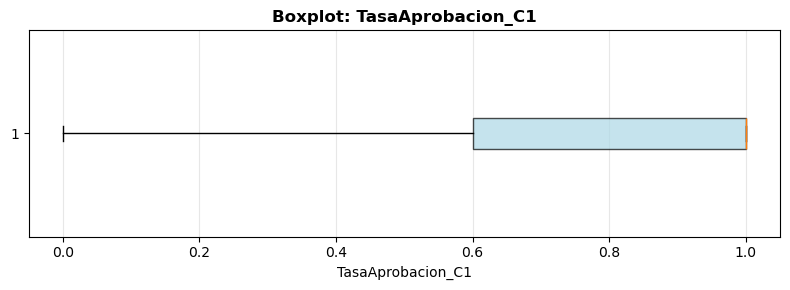

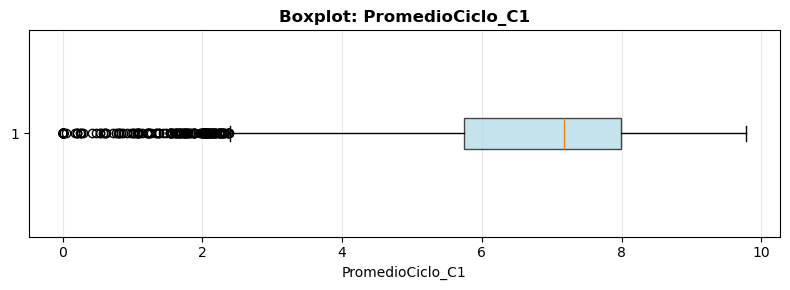

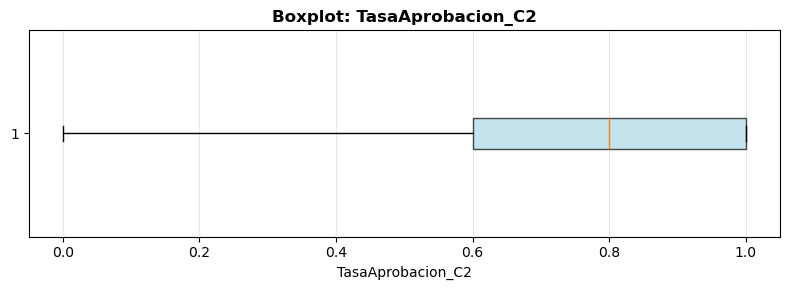

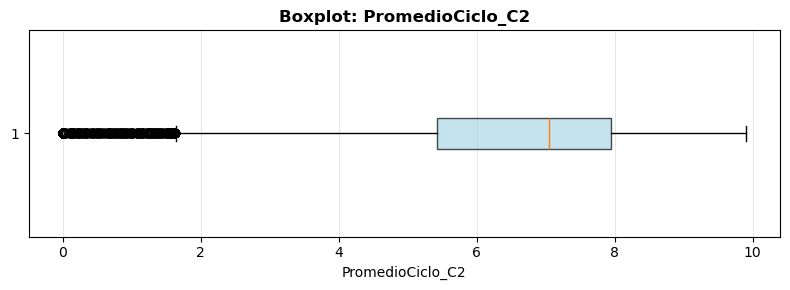

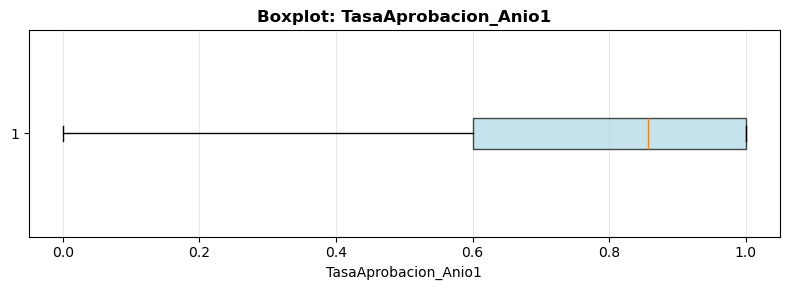

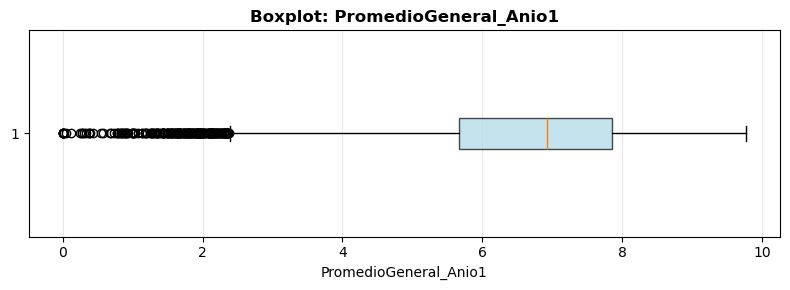

In [12]:

# 2.8 Análisis de variables numéricas
print("ANÁLISIS DE VARIABLES NUMÉRICAS")

# Histogramas de variables numéricas
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Distribución: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Boxplots para detectar outliers
for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    plt.boxplot(df[col].dropna(), vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
    plt.title(f"Boxplot: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


ANÁLISIS DE VARIABLES CATEGÓRICAS


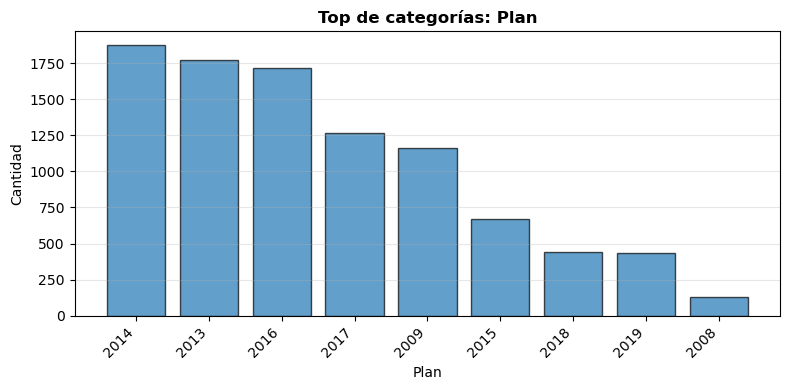

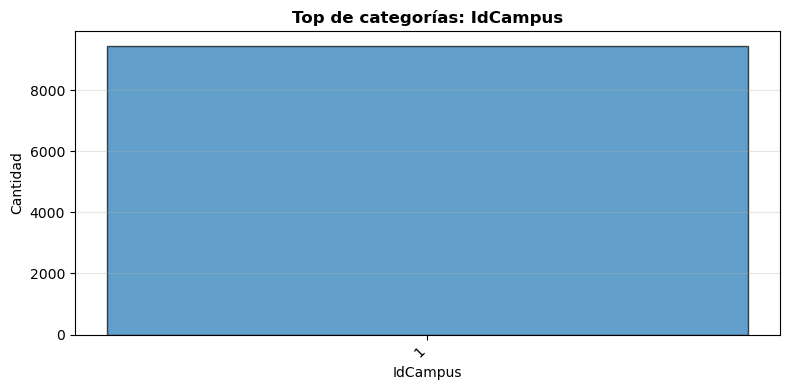

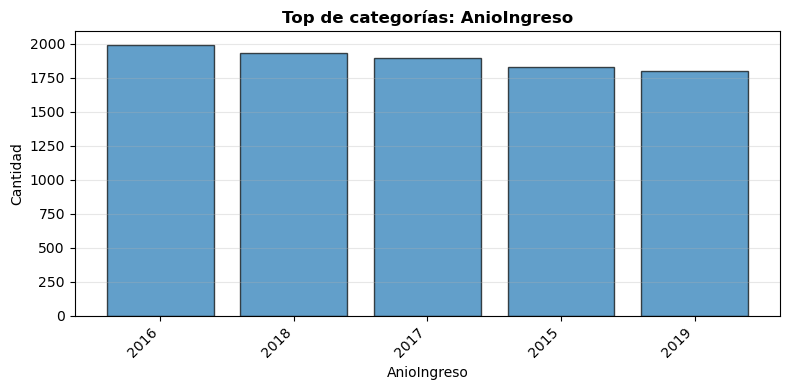

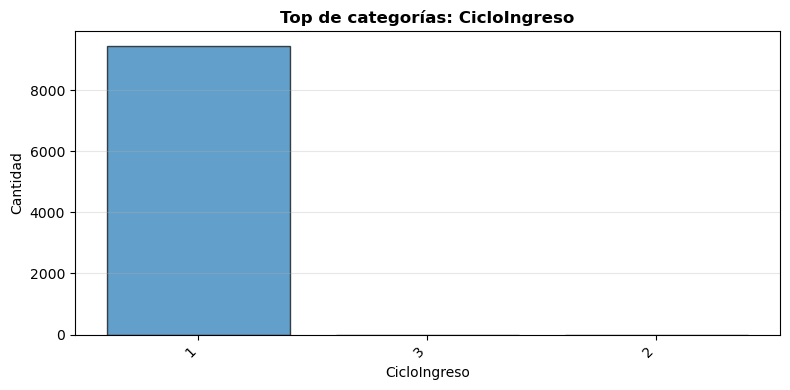

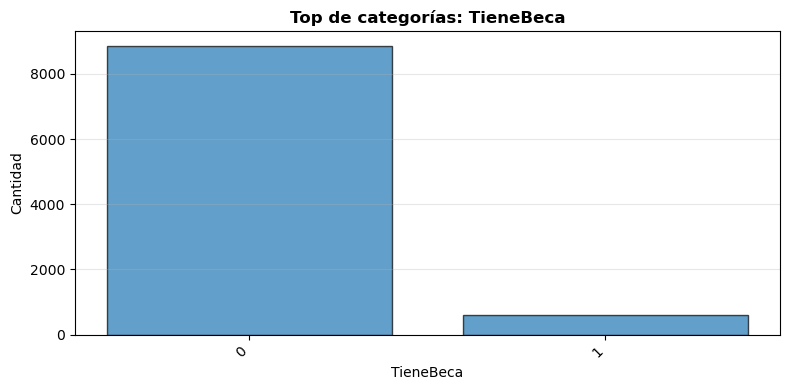

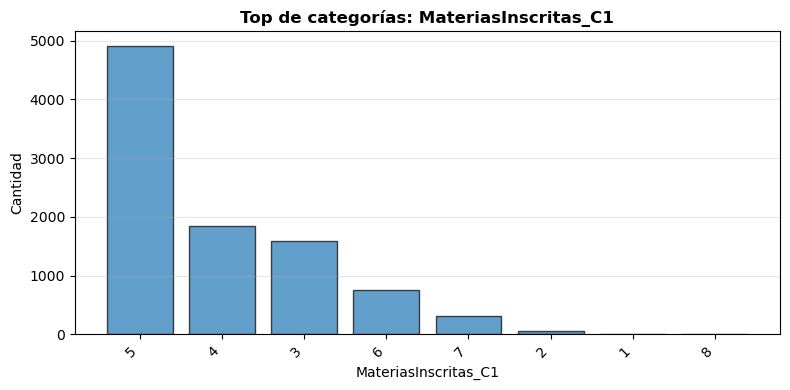

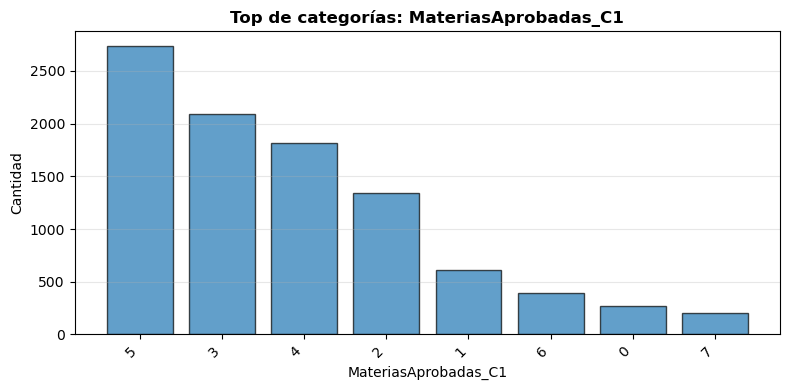

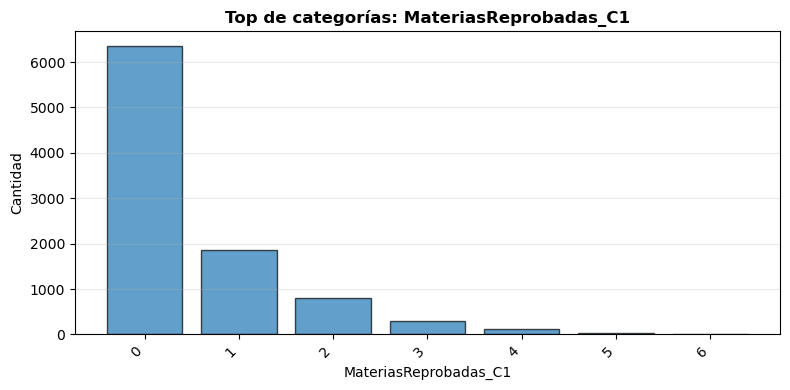

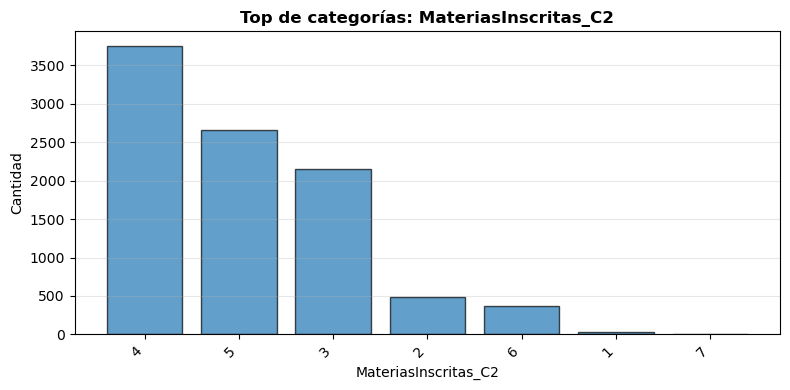

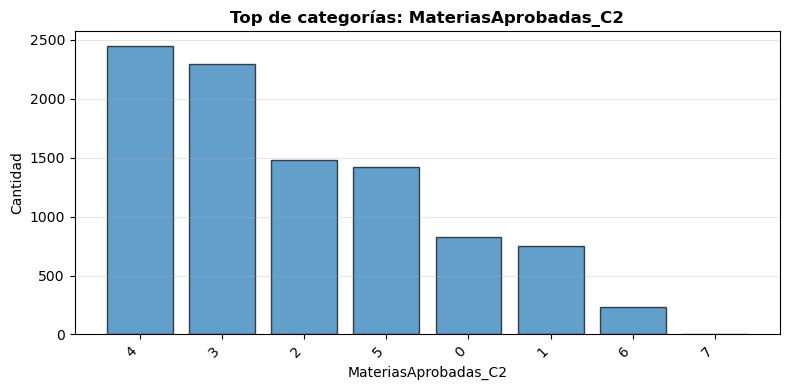

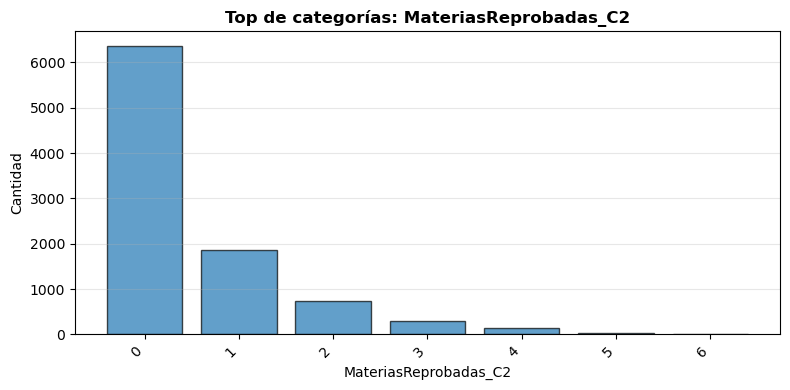

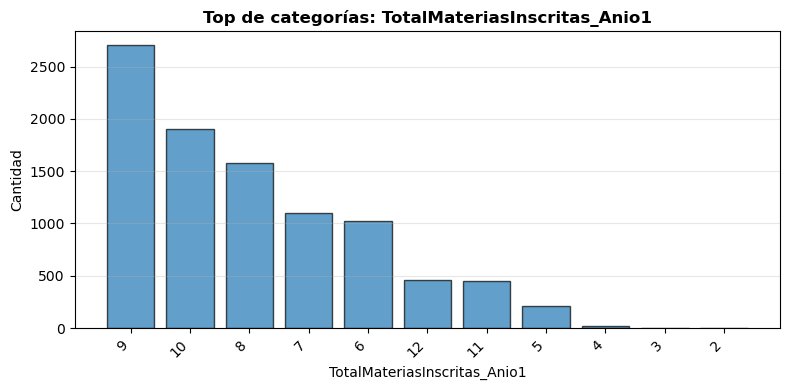

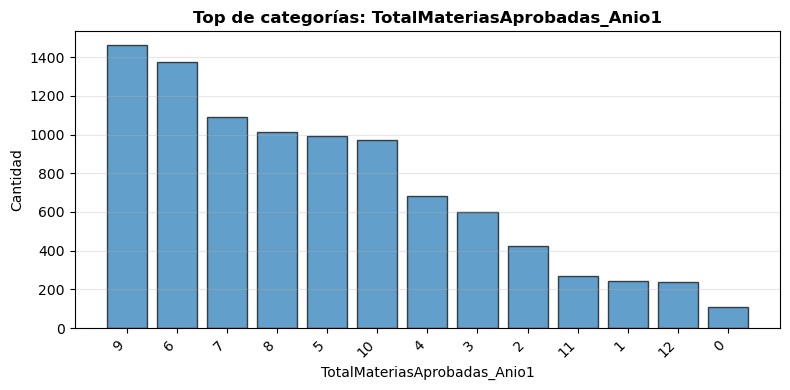

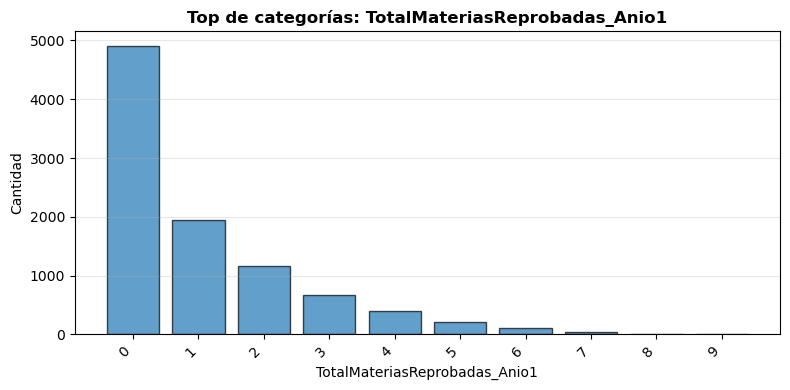

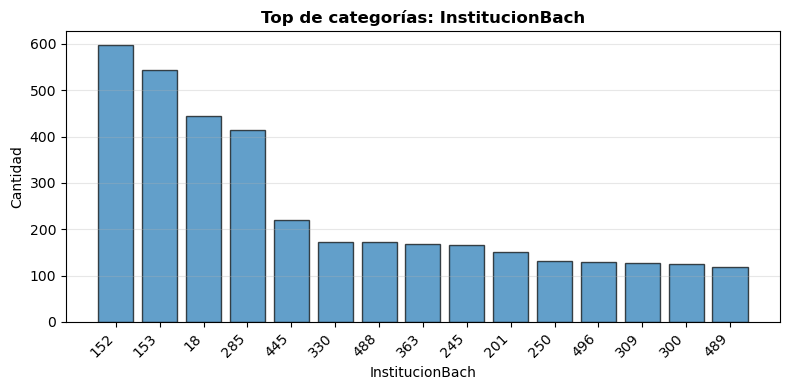

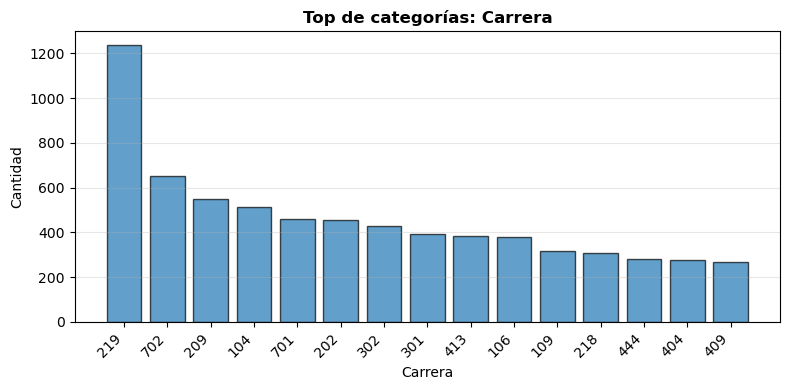

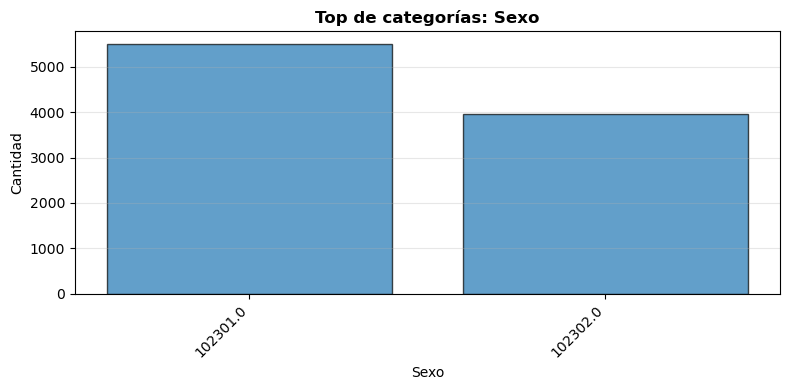

In [13]:

# 2.9 Análisis de variables categóricas
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")

# Conteos de variables categóricas
for col in categorical_cols:
    vc = df[col].value_counts().head(15)  # top 15 categorías
    
    plt.figure(figsize=(8, 4))
    plt.bar(vc.index.astype(str), vc.values, edgecolor='black', alpha=0.7)
    plt.title(f"Top de categorías: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Cantidad", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 3.3 Valores faltantes (missing values)

- Se calcula el porcentaje de nulos por columna.
- Se visualiza un resumen.


ANÁLISIS DE VALORES NULOS

 Columnas con valores nulos: 2

Top de columnas con mayor porcentaje de nulos:
PorcentajeBeca_Promedio    0.936780
Sexo                       0.000106
dtype: float64


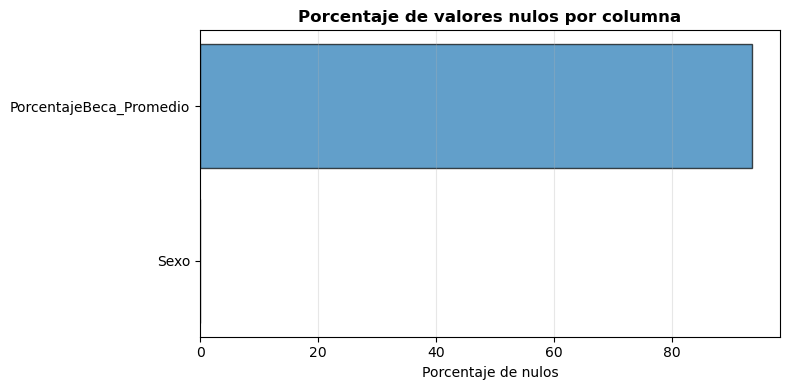

In [14]:

# 2.10 Análisis de valores nulos

print("ANÁLISIS DE VALORES NULOS")

missing = df.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

print(f"\n Columnas con valores nulos: {len(missing)}")
if len(missing) > 0:
    print("\nTop de columnas con mayor porcentaje de nulos:")
    print(missing.head(20))
    
    # Gráfico de porcentaje de nulos por columna
    plt.figure(figsize=(8, max(4, 0.3*len(missing))))
    plt.barh(missing.index[::-1], (missing.values[::-1]*100), edgecolor='black', alpha=0.7)
    plt.title("Porcentaje de valores nulos por columna", fontsize=12, fontweight='bold')
    plt.xlabel("Porcentaje de nulos", fontsize=10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n No hay valores nulos en el dataset.")

### 3.4 Análisis bivariado/multivariado

- Relación de cada feature con `Deserto`.
- Correlación entre variables numéricas.


CORRELACIÓN CON LA VARIABLE OBJETIVO

Top correlaciones con 'Deserto':
TasaAprobacion_C2         -0.350465
PromedioCiclo_C2          -0.336031
TasaAprobacion_Anio1      -0.269506
PromedioGeneral_Anio1     -0.267607
PorcentajeBeca_Promedio    0.170538
TasaAprobacion_C1         -0.121957
PromedioCiclo_C1          -0.114927
Name: Deserto, dtype: float64


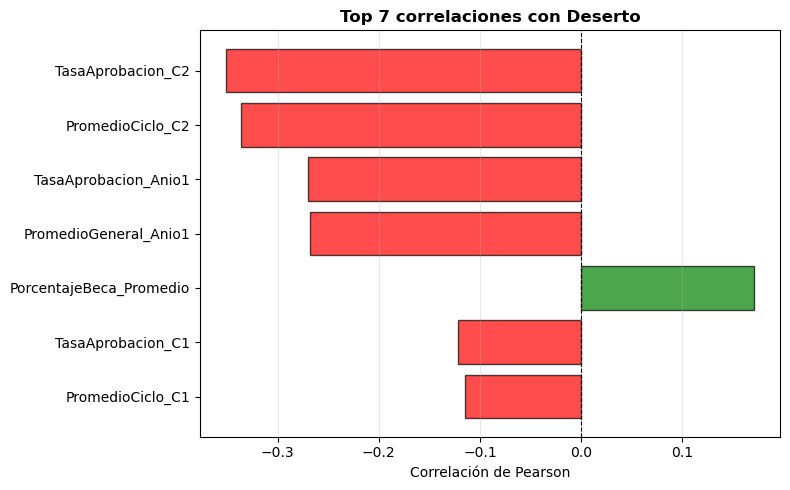

In [15]:

# 2.11 Correlación con la variable objetivo
print("CORRELACIÓN CON LA VARIABLE OBJETIVO")


# Correlación con la variable objetivo (solo numéricas)
corr = df[numeric_cols + [target_col]].corr(numeric_only=True)[target_col].drop(target_col).sort_values(key=lambda s: s.abs(), ascending=False)

print("\nTop correlaciones con 'Deserto':")
print(corr.head(15))

# Gráfico: Top correlaciones absolutas con Deserto
topk = min(12, len(corr))
top_corr = corr.iloc[:topk][::-1]

plt.figure(figsize=(8, 5))
colors = ['red' if x < 0 else 'green' for x in top_corr.values]
plt.barh(top_corr.index, top_corr.values, color=colors, edgecolor='black', alpha=0.7)
plt.title(f"Top {topk} correlaciones con Deserto", fontsize=12, fontweight='bold')
plt.xlabel("Correlación de Pearson", fontsize=10)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


TASA DE DESERCIÓN POR CATEGORÍA

--- Tasa de deserción por Plan ---
      count  tasa_desercion
Plan                       
2014   1876        0.113006
2013   1774        0.155581
2016   1714        0.082847
2017   1265        0.087747
2009   1159        0.148404
2015    667        0.128936
2018    443        0.085779
2019    431        0.109049
2008    130        0.192308


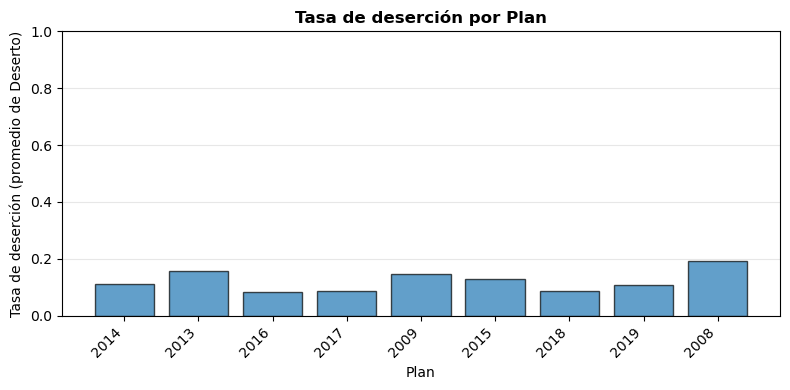


--- Tasa de deserción por IdCampus ---
          count  tasa_desercion
IdCampus                       
1          9459        0.117243


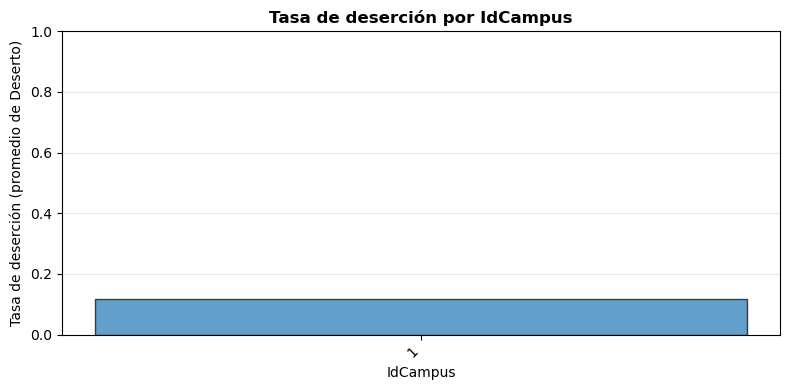


--- Tasa de deserción por AnioIngreso ---
             count  tasa_desercion
AnioIngreso                       
2016          1993        0.117913
2018          1936        0.109504
2017          1897        0.108593
2015          1831        0.147460
2019          1802        0.103219


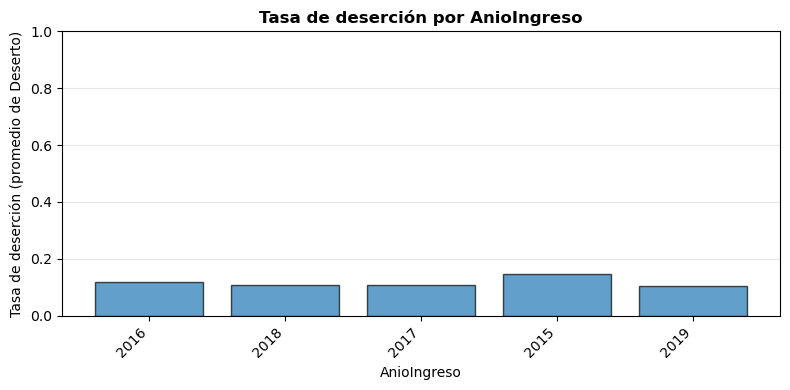


--- Tasa de deserción por CicloIngreso ---
              count  tasa_desercion
CicloIngreso                       
1              9457        0.117268
2                 1        0.000000
3                 1        0.000000


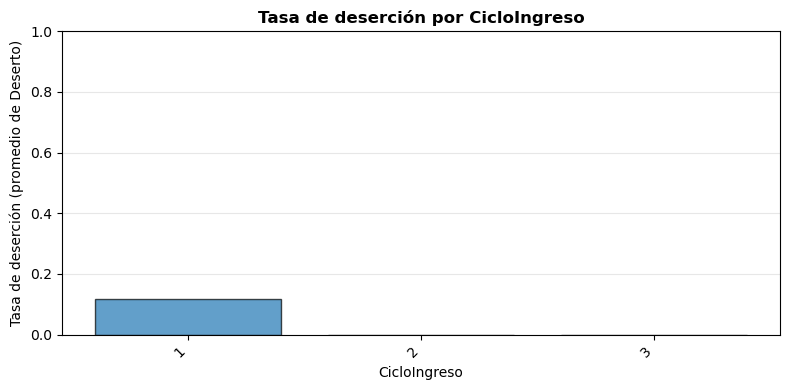


--- Tasa de deserción por TieneBeca ---
           count  tasa_desercion
TieneBeca                       
0           8861        0.120867
1            598        0.063545


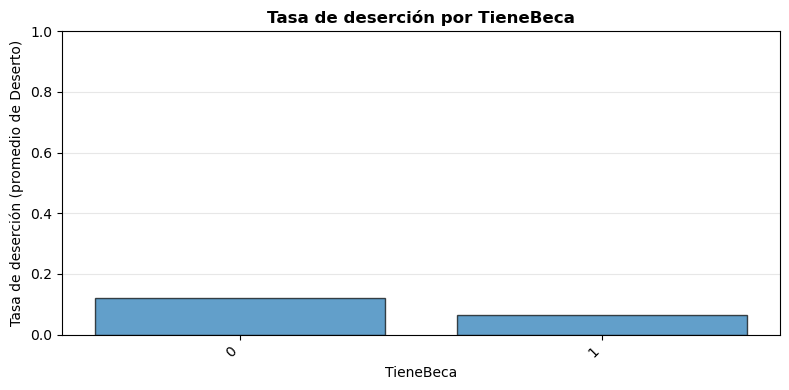


--- Tasa de deserción por MateriasInscritas_C1 ---
                      count  tasa_desercion
MateriasInscritas_C1                       
5                      4913        0.105842
4                      1840        0.106522
3                      1590        0.121384
6                       754        0.169761
7                       306        0.212418
2                        53        0.075472
1                         2        1.000000
8                         1        1.000000


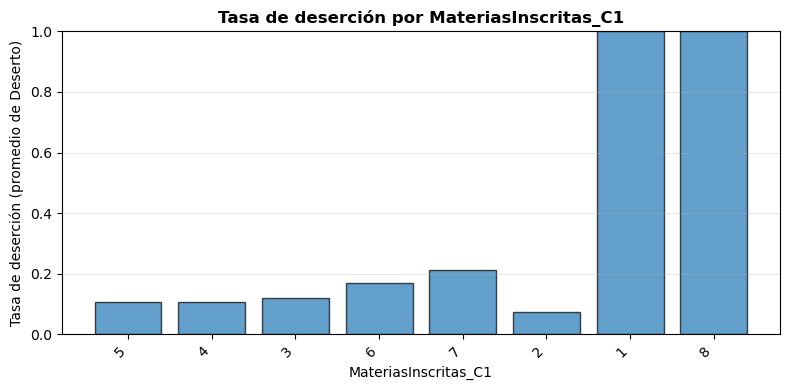


--- Tasa de deserción por MateriasAprobadas_C1 ---
                      count  tasa_desercion
MateriasAprobadas_C1                       
5                      2739        0.083607
3                      2092        0.108509
4                      1816        0.091960
2                      1346        0.161218
1                       609        0.178982
6                       390        0.176923
0                       265        0.237736
7                       202        0.138614


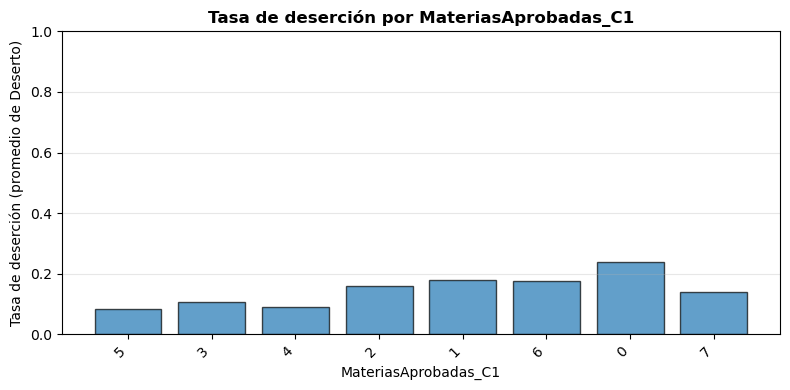


--- Tasa de deserción por MateriasReprobadas_C1 ---
                       count  tasa_desercion
MateriasReprobadas_C1                       
0                       6359        0.089951
1                       1849        0.152515
2                        799        0.206508
3                        295        0.166102
4                        115        0.252174
5                         41        0.292683
6                          1        0.000000


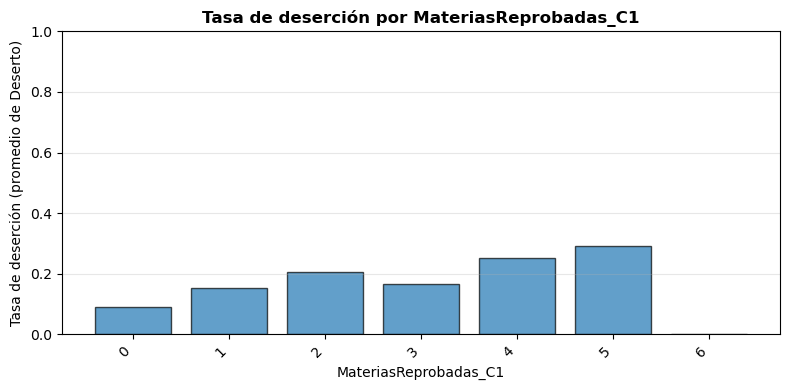


--- Tasa de deserción por MateriasInscritas_C2 ---
                      count  tasa_desercion
MateriasInscritas_C2                       
4                      3756        0.092386
5                      2661        0.108606
3                      2150        0.151163
2                       489        0.196319
6                       368        0.133152
1                        33        0.090909
7                         2        0.000000


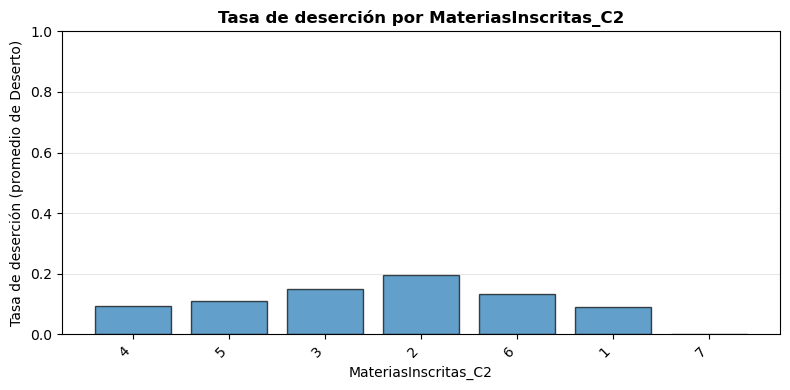


--- Tasa de deserción por MateriasAprobadas_C2 ---
                      count  tasa_desercion
MateriasAprobadas_C2                       
4                      2450        0.042449
3                      2292        0.053665
2                      1481        0.091155
5                      1422        0.089311
0                       824        0.509709
1                       754        0.216180
6                       234        0.158120
7                         2        0.000000


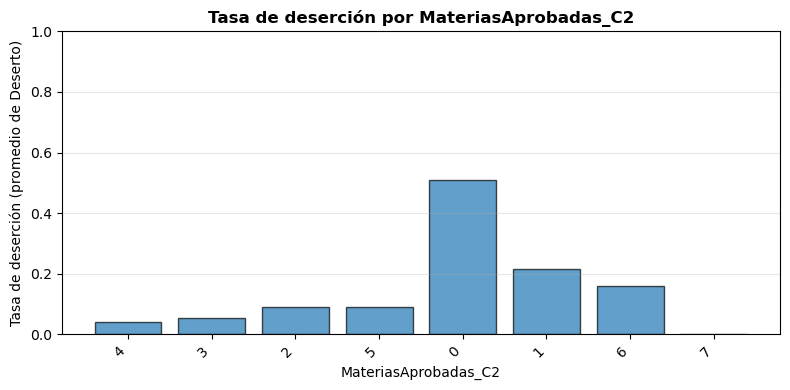


--- Tasa de deserción por MateriasReprobadas_C2 ---
                       count  tasa_desercion
MateriasReprobadas_C2                       
0                       6369        0.079290
1                       1870        0.103209
2                        746        0.230563
3                        304        0.440789
4                        138        0.601449
5                         30        0.666667
6                          2        1.000000


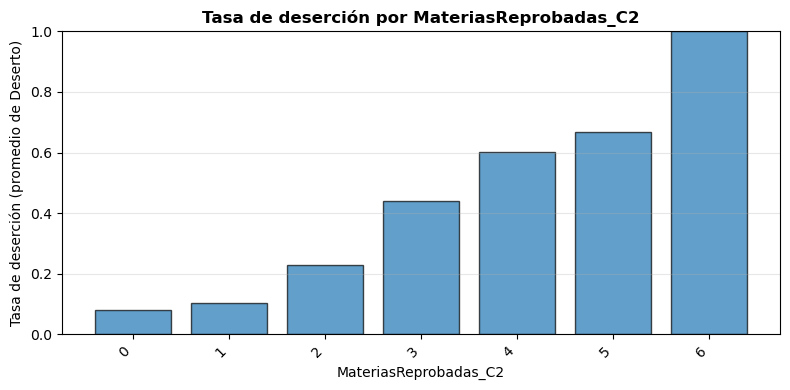


--- Tasa de deserción por TotalMateriasInscritas_Anio1 ---
                              count  tasa_desercion
TotalMateriasInscritas_Anio1                       
9                              2701        0.081081
10                             1907        0.088096
8                              1578        0.137516
7                              1101        0.163488
6                              1024        0.118164
12                              459        0.178649
11                              452        0.199115
5                               211        0.137441
4                                23        0.043478
3                                 2        0.500000


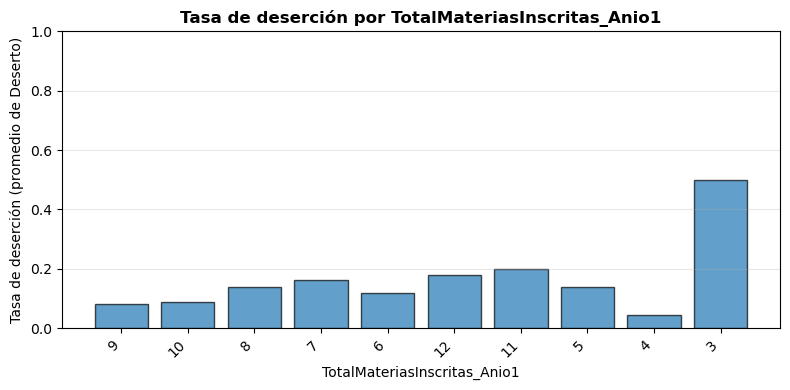


--- Tasa de deserción por TotalMateriasAprobadas_Anio1 ---
                              count  tasa_desercion
TotalMateriasAprobadas_Anio1                       
9                              1460        0.031507
6                              1374        0.065502
7                              1089        0.052342
8                              1015        0.056158
5                               990        0.129293
10                              972        0.108025
4                               680        0.205882
3                               599        0.237062
2                               425        0.317647
11                              267        0.119850


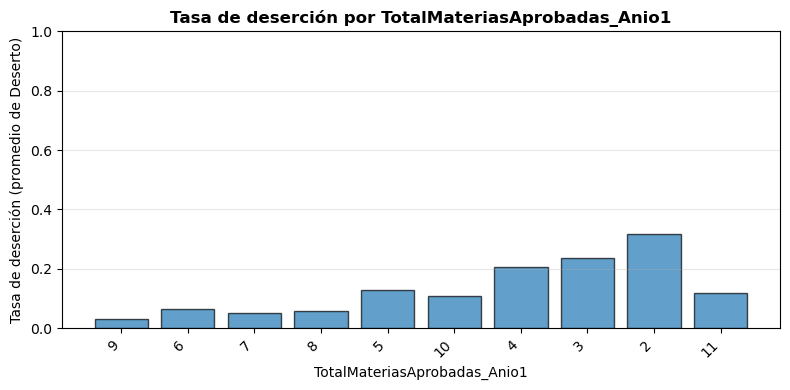


--- Tasa de deserción por TotalMateriasReprobadas_Anio1 ---
                               count  tasa_desercion
TotalMateriasReprobadas_Anio1                       
0                               4909        0.068446
1                               1944        0.091564
2                               1163        0.147034
3                                665        0.216541
4                                398        0.314070
5                                215        0.427907
6                                109        0.376147
7                                 44        0.363636
8                                 11        0.545455
9                                  1        0.000000


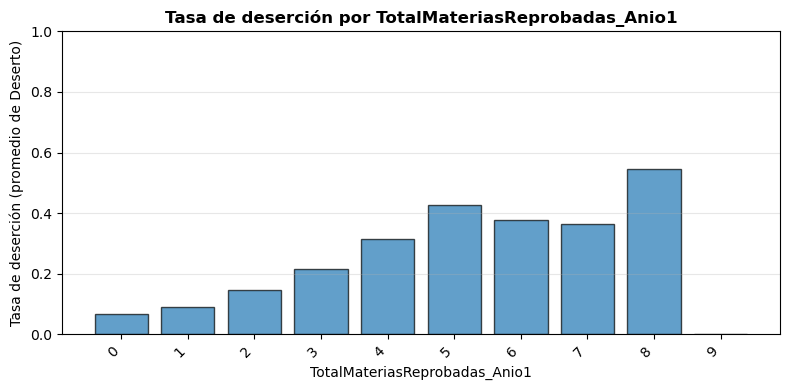


--- Tasa de deserción por InstitucionBach ---
                 count  tasa_desercion
InstitucionBach                       
152                597        0.145729
153                544        0.134191
18                 444        0.247748
285                413        0.099274
445                221        0.081448
330                172        0.110465
488                172        0.052326
363                168        0.428571
245                167        0.065868
201                151        0.099338


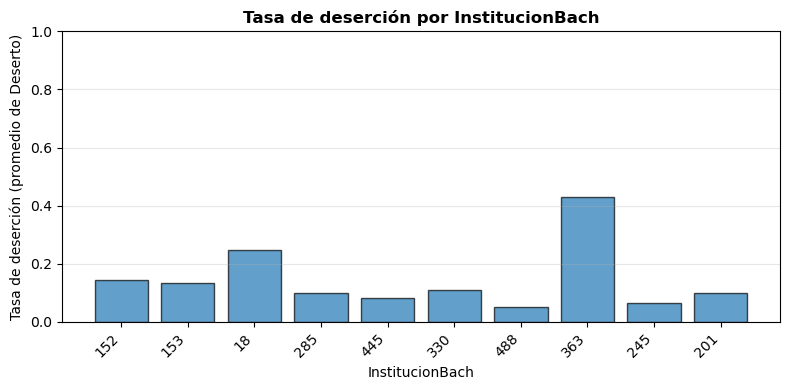


--- Tasa de deserción por Carrera ---
         count  tasa_desercion
Carrera                       
219       1236        0.114887
702        653        0.150077
209        547        0.089580
104        515        0.093204
701        462        0.103896
202        454        0.072687
302        428        0.060748
301        392        0.061224
413        385        0.088312
106        379        0.092348


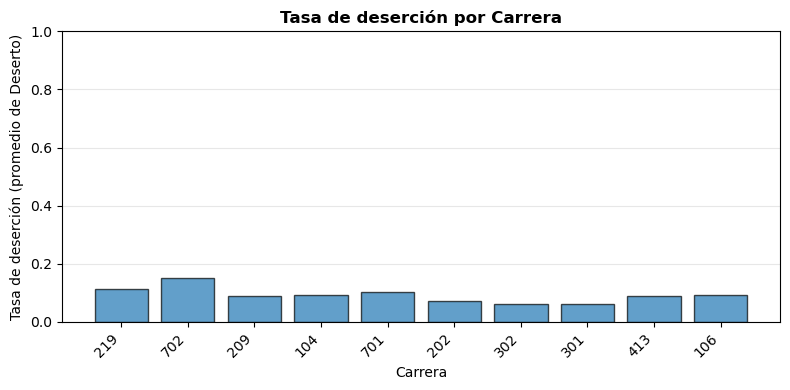


--- Tasa de deserción por Sexo ---
          count  tasa_desercion
Sexo                           
102301.0   5505        0.137693
102302.0   3953        0.088793


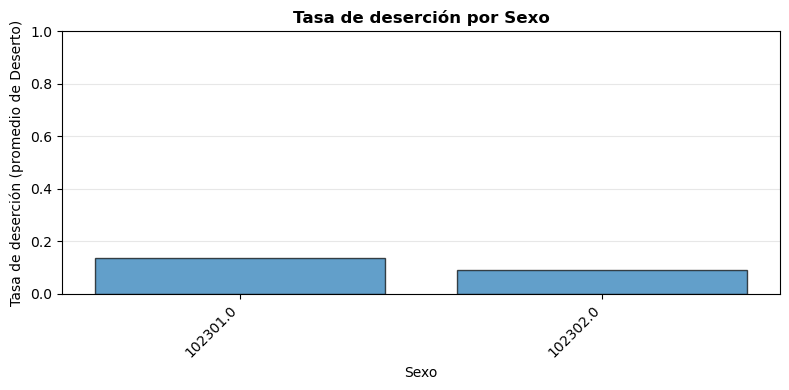

In [16]:

# 2.13 Tasa de deserción por categoría

print("TASA DE DESERCIÓN POR CATEGORÍA")

# Tasa de deserción por categoría para columnas categóricas
for col in categorical_cols:
    tmp = (
        df.groupby(col)[target_col]
          .agg(['count', 'mean'])
          .rename(columns={'mean': 'tasa_desercion'})
          .sort_values('count', ascending=False)
          .head(10)
    )
    
    print(f"\n--- Tasa de deserción por {col} ---")
    print(tmp)
    
    plt.figure(figsize=(8, 4))
    plt.bar(tmp.index.astype(str), tmp['tasa_desercion'].values, edgecolor='black', alpha=0.7)
    plt.title(f"Tasa de deserción por {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Tasa de deserción (promedio de Deserto)", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

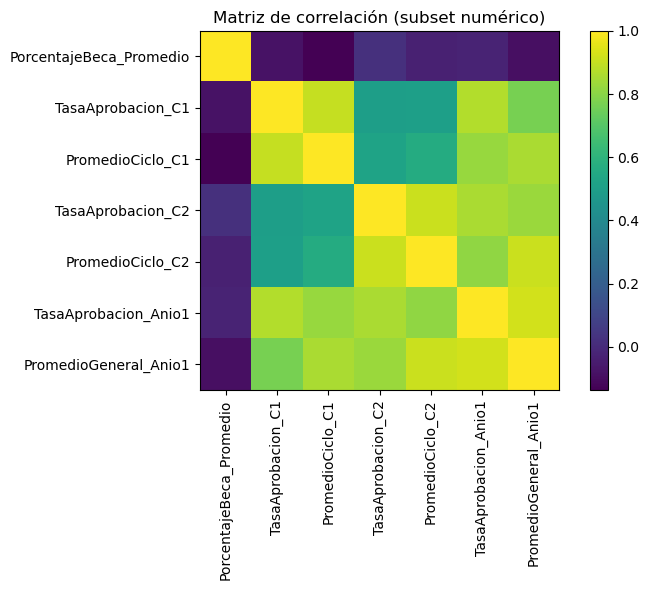

In [17]:
# Matriz de correlación entre numéricas (muestra: primeras 12 para legibilidad)
num_subset = numeric_cols
corr_mat = df[num_subset].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr_mat.values)
plt.title("Matriz de correlación (subset numérico)")
plt.xticks(range(len(num_subset)), num_subset, rotation=90)
plt.yticks(range(len(num_subset)), num_subset)
plt.colorbar()
plt.tight_layout()
plt.show()


## 4. División de datos y estrategia de validación

### 4.1 Objetivo
Separar datos en **train** y **test** antes de cualquier preprocesamiento, para evitar fuga de información.

### 4.2 Estrategia propuesta
- **Train/Test split:** 80/20
- **Estratificación:** Sí (por `Deserto`) para mantener proporción de clases.
- **Semilla:** `RANDOM_SEED = 42`
- **Validación interna:** `StratifiedKFold` con 5 folds sobre train.

> La optimización de hiperparámetros y selección de modelo se hará usando solo train (con CV). El test se usa **una sola vez** al final.


In [18]:
# 2.14 División del dataset (Train/Test)

print("DIVISIÓN DEL DATASET")

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"\n Train: {X_train.shape}, Test: {X_test.shape}")

print("\nProporción de clases en y (total):")
print(y.value_counts(normalize=True).round(4))

print("\nProporción de clases en y_train:")
print(y_train.value_counts(normalize=True).round(4))

print("\nProporción de clases en y_test:")
print(y_test.value_counts(normalize=True).round(4))

DIVISIÓN DEL DATASET

 Train: (7567, 24), Test: (1892, 24)

Proporción de clases en y (total):
Deserto
0    0.8828
1    0.1172
Name: proportion, dtype: float64

Proporción de clases en y_train:
Deserto
0    0.8828
1    0.1172
Name: proportion, dtype: float64

Proporción de clases en y_test:
Deserto
0    0.8827
1    0.1173
Name: proportion, dtype: float64


In [19]:

# 2.15 Configuración de validación cruzada estratificada

print("CONFIGURACIÓN DE VALIDACIÓN CRUZADA")

# Configuración de Cross-Validation Estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tamaños por fold
fold_sizes = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    fold_sizes.append((fold, len(tr_idx), len(val_idx)))

fold_df = pd.DataFrame(fold_sizes, columns=["fold", "train_size", "val_size"])
print("\n Tamaños de cada fold:")
print(fold_df)


CONFIGURACIÓN DE VALIDACIÓN CRUZADA

 Tamaños de cada fold:
   fold  train_size  val_size
0     1        6053      1514
1     2        6053      1514
2     3        6054      1513
3     4        6054      1513
4     5        6054      1513


5. Preprocesamiento y Feature Engineering 

In [20]:

#  Definición de transformadores (Preprocesamiento)
print("CONFIGURACIÓN DEL PREPROCESAMIENTO")


# Pipeline para variables numéricas: Imputación por mediana + Escalado estándar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas: Imputación por valor más frecuente + One-Hot Encoding
# Cambiamos la estrategia a 'most_frequent' para evitar problemas con int64
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print(f" Preprocesador configurado para {len(numeric_cols)} numéricas y {len(categorical_cols)} categóricas.")


# Definición de Modelos y Grillas de Hiperparámetros


# 1. Regresión Logística (Baseline)
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2']
}

# 2. K-Nearest Neighbors (Basado en Distancia)
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance']
}

# 3. XGBoost (Ensamble de Gradient Boosting)
# Calculamos el factor de desbalance para scale_pos_weight
ratio_desbalance = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=ratio_desbalance # Manejo de desbalance
    ))
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Lista de modelos para iterar
models_to_train = [
    ("Regresión Logística", lr_model, lr_param_grid),
    ("K-Nearest Neighbors", knn_model, knn_param_grid),
    ("XGBoost", xgb_model, xgb_param_grid)
]

print("\n Modelos configurados:")
for name, _, params in models_to_train:
    print(f"  - {name}: {len(list(params.values())[0]) if params else 0} combinaciones de hiperparámetros")

CONFIGURACIÓN DEL PREPROCESAMIENTO
 Preprocesador configurado para 7 numéricas y 17 categóricas.

 Modelos configurados:
  - Regresión Logística: 4 combinaciones de hiperparámetros
  - K-Nearest Neighbors: 4 combinaciones de hiperparámetros
  - XGBoost: 2 combinaciones de hiperparámetros


ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS

ENTRENANDO Regresión Logística...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Regresión Logística finalizado en 11.67s
Mejores parámetros: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

ENTRENANDO K-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 K-Nearest Neighbors finalizado en 4.46s
Mejores parámetros: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}

ENTRENANDO XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\arani\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:05:12] WARNING: D:\bld\xgboost-split_1770963345048\work\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost finalizado en 56.85s
Mejores parámetros: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

RESUMEN DE RENDIMIENTO EN TEST
             Modelo  Mejor F1 (CV)  F1-Score (Test)  Recall (Test)  Precision (Test)  Accuracy (Test)  Tiempo (s)
Regresión Logística         0.4652           0.4683         0.7477            0.3409           0.8007       11.67
            XGBoost         0.5022           0.4662         0.5901            0.3853           0.8414       56.85
K-Nearest Neighbors         0.4339           0.4615         0.3649            0.6279           0.9001        4.46


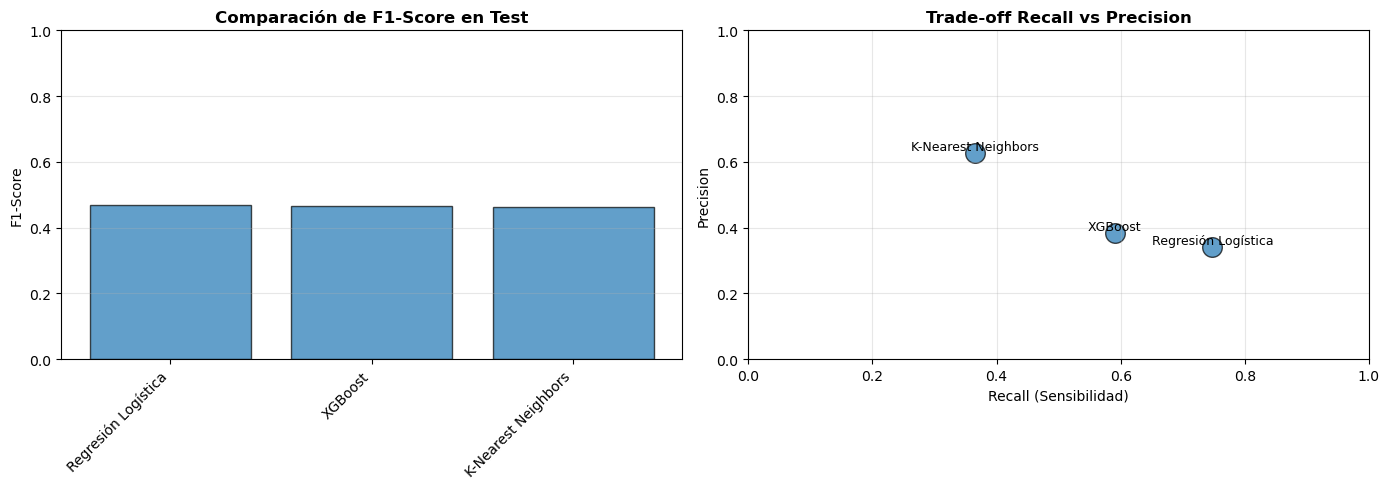

In [21]:

#  Ejecución del entrenamiento comparativo
print("ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS")


best_models = {}
results_summary = []

for name, pipeline, params in models_to_train:
    print(f"\nENTRENANDO {name}...")
    start_time = time.time()
    
    # Usamos F1-Score como métrica de optimización debido al contexto de deserción
    grid_search = GridSearchCV(
        pipeline, 
        params, 
        cv=skf, 
        scoring='f1', # Optimizamos para balancear precisión y recall
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    
    # Guardar el mejor modelo
    best_models[name] = grid_search.best_estimator_
    
    # Evaluación en Test
    y_pred = grid_search.predict(X_test)
    
    metrics = {
        "Modelo": name,
        "Mejor F1 (CV)": round(grid_search.best_score_, 4),
        "F1-Score (Test)": round(f1_score(y_test, y_pred), 4),
        "Recall (Test)": round(recall_score(y_test, y_pred), 4),
        "Precision (Test)": round(precision_score(y_test, y_pred), 4),
        "Accuracy (Test)": round(accuracy_score(y_test, y_pred), 4),
        "Tiempo (s)": round(end_time - start_time, 2)
    }
    
    results_summary.append(metrics)
    print(f" {name} finalizado en {metrics['Tiempo (s)']}s")
    print(f"Mejores parámetros: {grid_search.best_params_}")


#  Resumen de Resultados

df_results = pd.DataFrame(results_summary).sort_values(by="F1-Score (Test)", ascending=False)
print("\n" + "="*60)
print("RESUMEN DE RENDIMIENTO EN TEST")
print("="*60)
print(df_results.to_string(index=False))

# Visualización comparativa de métricas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: F1-Score comparativo
ax1 = axes[0]
x_pos = range(len(df_results))
ax1.bar(x_pos, df_results["F1-Score (Test)"], alpha=0.7, edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_results["Modelo"], rotation=45, ha='right')
ax1.set_ylabel("F1-Score", fontsize=10)
ax1.set_title("Comparación de F1-Score en Test", fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Recall vs Precision
ax2 = axes[1]
ax2.scatter(df_results["Recall (Test)"], df_results["Precision (Test)"], 
            s=200, alpha=0.7, edgecolor='black')
for i, model in enumerate(df_results["Modelo"]):
    ax2.annotate(model, 
                 (df_results["Recall (Test)"].iloc[i], df_results["Precision (Test)"].iloc[i]),
                 fontsize=9, ha='center', va='bottom')
ax2.set_xlabel("Recall (Sensibilidad)", fontsize=10)
ax2.set_ylabel("Precision", fontsize=10)
ax2.set_title("Trade-off Recall vs Precision", fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Selección e Interpretación del Modelo Final (XGBoost)
# Selección del modelo final (Desempeño + negocio + tiempo)


# F1-Score en TEST
final_model_name = df_results.sort_values("F1-Score (Test)", ascending=False).iloc[0]["Modelo"]
final_model = best_models[final_model_name]

print("\n" + "="*70)
print("MODELO FINAL SELECCIONADO")
print("="*70)
print(f"Modelo final: {final_model_name}")

# Métricas
row = df_results[df_results["Modelo"] == final_model_name].iloc[0]
print("\nJustificación basada en métricas relevantes (TEST):")
print(f"- F1-Score (Test): {row['F1-Score (Test)']:.4f}  (criterio principal por desbalance)")
print(f"- Recall (Test)  : {row['Recall (Test)']:.4f}")
print(f"- Precision (Test): {row['Precision (Test)']:.4f}")
print(f"- Accuracy (Test): {row['Accuracy (Test)']:.4f}")
print(f"- Tiempo entrenamiento (s): {row['Tiempo (s)']:.2f}")



MODELO FINAL SELECCIONADO
Modelo final: Regresión Logística

Justificación basada en métricas relevantes (TEST):
- F1-Score (Test): 0.4683  (criterio principal por desbalance)
- Recall (Test)  : 0.7477
- Precision (Test): 0.3409
- Accuracy (Test): 0.8007
- Tiempo entrenamiento (s): 11.67



ROBUSTEZ / GENERALIZACIÓN (CV en Train)
F1       : 0.4652 ± 0.0214
RECALL   : 0.7351 ± 0.0447
PRECISION: 0.3404 ± 0.0135
ACCURACY : 0.8022 ± 0.0054

TIEMPO DE INFERENCIA (aprox.)
Inferencia sobre 1892 registros: 0.0228s  |  0.012041 ms/registro

EVALUACIÓN DETALLADA DEL MODELO FINAL (TEST)
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1670
           1       0.34      0.75      0.47       222

    accuracy                           0.80      1892
   macro avg       0.65      0.78      0.67      1892
weighted avg       0.89      0.80      0.83      1892



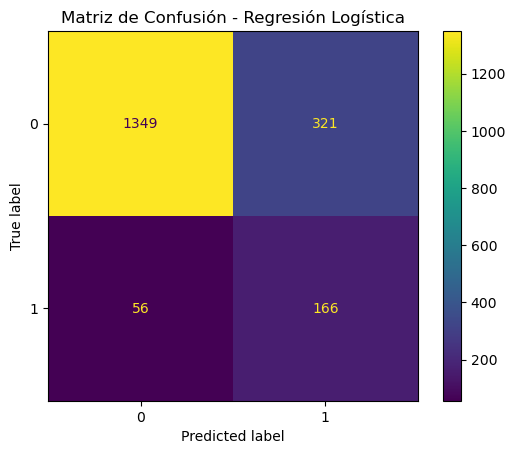

ROC-AUC (Test): 0.8325
PR-AUC / Average Precision (Test): 0.4532


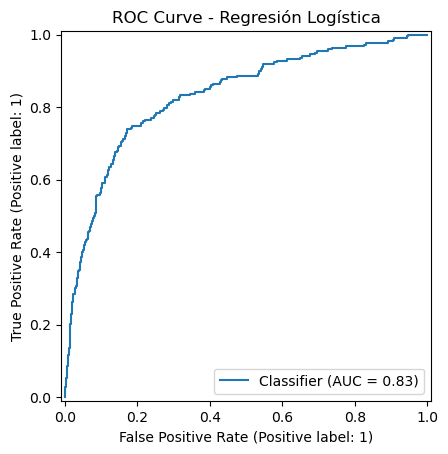

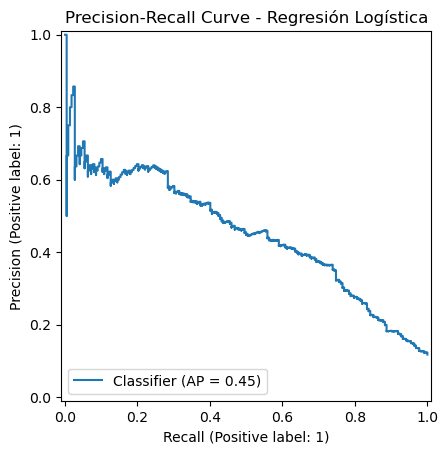

In [23]:
# Robustez y generalización (CV)

skf_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"f1": "f1", "recall": "recall", "precision": "precision", "accuracy": "accuracy"}

cv_out = cross_validate(final_model, X_train, y_train, cv=skf_final, scoring=scoring, n_jobs=-1)

print("\n" + "="*70)
print("ROBUSTEZ / GENERALIZACIÓN (CV en Train)")
print("="*70)
for k in ["test_f1", "test_recall", "test_precision", "test_accuracy"]:
    print(f"{k.replace('test_', '').upper():9s}: {cv_out[k].mean():.4f} ± {cv_out[k].std():.4f}")

# Tiempo de inferencia

N_INFER = min(5000, len(X_test))
X_infer = X_test.iloc[:N_INFER].copy() if hasattr(X_test, "iloc") else X_test[:N_INFER]

t0 = time.time()
_ = final_model.predict(X_infer)
t1 = time.time()

print("\n" + "="*70)
print("TIEMPO DE INFERENCIA (aprox.)")
print("="*70)
print(f"Inferencia sobre {N_INFER} registros: {(t1 - t0):.4f}s  |  {(t1 - t0)/N_INFER*1000:.6f} ms/registro")

# Interpretación del modelo (XGBoost)

# Evaluación detallada en TEST (reporte, matriz, ROC/PR)


y_pred_final = final_model.predict(X_test)

print("\n" + "="*70)
print("EVALUACIÓN DETALLADA DEL MODELO FINAL (TEST)")
print("="*70)
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title(f"Matriz de Confusión - {final_model_name}")
plt.show()

# Curvas ROC y PR
if hasattr(final_model, "predict_proba"):
    y_proba_final = final_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba_final)
    ap = average_precision_score(y_test, y_proba_final)

    print(f"ROC-AUC (Test): {roc_auc:.4f}")
    print(f"PR-AUC / Average Precision (Test): {ap:.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba_final)
    plt.title(f"ROC Curve - {final_model_name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba_final)
    plt.title(f"Precision-Recall Curve - {final_model_name}")
    plt.show()
else:
    print("[INFO] El modelo no soporta predict_proba")


In [24]:
# Feature importance (XGBoost)

def get_feature_names_from_pipeline(fitted_pipeline):
    
    pre = fitted_pipeline.named_steps.get("preprocessor", None)
    if pre is None:
        return None
    try:
        return pre.get_feature_names_out()
    except Exception:
        return None

feat_names = get_feature_names_from_pipeline(final_model)
clf = final_model.named_steps.get("classifier", final_model)

print("\n" + "="*70)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*70)

if feat_names is not None and hasattr(clf, "feature_importances_"):
    imps = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False)

    print("Top 20 variables más influyentes:")
    print(imps.head(20).to_string())

    imps.head(20).sort_values().plot(kind="barh")
    plt.title(f"Top 20 Feature Importance - {final_model_name}")
    plt.xlabel("Importancia")
    plt.show()

    print("\nInterpretación:")
    print("- La importancia es una medida global de contribución del feature al modelo.")
    print("- No implica causalidad; indica qué variables ayudan más a separar clases.")
else:
    print("[WARN] No se pudieron obtener nombres/feature_importances_.")
    print("       Revisa que tu Pipeline tenga un paso llamado 'preprocessor' y 'classifier'.")


# Análisis de errores (FN/FP)


print("\n" + "="*70)
print("ANÁLISIS DE ERRORES (FN/FP)")
print("="*70)

err_df = X_test.copy() if hasattr(X_test, "copy") else pd.DataFrame(X_test)
err_df = err_df.reset_index(drop=True)

y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_final).reset_index(drop=True)

err_df["y_real"] = y_test_series
err_df["y_pred"] = y_pred_series

false_negatives = err_df[(err_df["y_real"] == 1) & (err_df["y_pred"] == 0)]
false_positives = err_df[(err_df["y_real"] == 0) & (err_df["y_pred"] == 1)]

print(f"Falsos Negativos (FN): {len(false_negatives)}  -> (casos positivos no detectados)")
print(f"Falsos Positivos (FP): {len(false_positives)}  -> (alertas incorrectas)")

N_SHOW = 10
print("\nEjemplos FN (top):")
display(false_negatives.head(N_SHOW))

print("\nEjemplos FP (top):")
display(false_positives.head(N_SHOW))


# Conclusión automática (texto base)

print("\n" + "="*70)
print("3.7 CONCLUSIÓN (BASE)")
print("="*70)

print(
    f"Se seleccionó {final_model_name} como modelo final debido a que obtuvo el mejor F1-Score en el conjunto de prueba "
    f"({row['F1-Score (Test)']:.4f}), lo cual es adecuado en escenarios con posible desbalance de clases. "
    f"Además, el desempeño en Recall ({row['Recall (Test)']:.4f}) y Precision ({row['Precision (Test)']:.4f}) muestra un balance "
    f"coherente entre detectar positivos y evitar falsas alarmas. "
    f"El modelo fue validado mediante CV (sección 3.7.1.2) para evidenciar robustez y generalización, "
    f"y se interpretó con feature importance (sección 3.7.2.2) para identificar variables influyentes. "
    f"Finalmente, el análisis de errores (FN/FP) permite entender en qué casos falla y orientar mejoras o ajustes de umbral."
)



FEATURE IMPORTANCE (XGBoost)
[WARN] No se pudieron obtener nombres/feature_importances_.
       Revisa que tu Pipeline tenga un paso llamado 'preprocessor' y 'classifier'.

ANÁLISIS DE ERRORES (FN/FP)
Falsos Negativos (FN): 56  -> (casos positivos no detectados)
Falsos Positivos (FP): 321  -> (alertas incorrectas)

Ejemplos FN (top):


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,y_real,y_pred
17,444,2009,1,102301.0,2019,1,152,0,NaN,7,7,0,1.0000,7.43,5,5,0,1.0000,7.28,12,12,0,1.0000,7.35,1,0
25,203,2016,1,102301.0,2016,1,209,0,NaN,5,5,0,1.0000,8.26,4,4,0,1.0000,8.12,9,9,0,1.0000,8.19,1,0
29,401,2019,1,102301.0,2019,1,614,0,NaN,5,3,0,0.6000,4.43,3,3,0,1.0000,8.51,8,6,0,0.7500,6.47,1,0
47,106,2009,1,102302.0,2015,1,233,0,NaN,5,5,0,1.0000,7.36,4,3,1,0.7500,6.63,9,8,1,0.8889,6.99,1,0
85,444,2009,1,102301.0,2019,1,152,0,NaN,7,7,0,1.0000,8.80,5,5,0,1.0000,8.92,12,12,0,1.0000,8.86,1,0
171,444,2009,1,102301.0,2019,1,152,0,NaN,7,7,0,1.0000,8.90,5,5,0,1.0000,9.24,12,12,0,1.0000,9.07,1,0
174,701,2013,1,102301.0,2017,1,496,0,NaN,6,5,1,0.8333,7.72,6,6,0,1.0000,8.31,12,11,1,0.9167,8.01,1,0
271,702,2014,1,102302.0,2019,1,176,0,NaN,5,2,2,0.4000,6.02,3,3,0,1.0000,7.57,8,5,2,0.6250,6.80,1,0
290,104,2017,1,102301.0,2018,1,659,0,NaN,4,2,1,0.5000,4.90,3,2,0,0.6667,4.45,7,4,1,0.5714,4.67,1,0
312,413,2016,1,102302.0,2015,1,156,0,NaN,5,5,0,1.0000,7.58,5,5,0,1.0000,8.04,10,10,0,1.0000,7.81,1,0



Ejemplos FP (top):


,Carrera,Plan,IdCampus,Sexo,AnioIngreso,CicloIngreso,InstitucionBach,TieneBeca,PorcentajeBeca_Promedio,MateriasInscritas_C1,MateriasAprobadas_C1,MateriasReprobadas_C1,TasaAprobacion_C1,PromedioCiclo_C1,MateriasInscritas_C2,MateriasAprobadas_C2,MateriasReprobadas_C2,TasaAprobacion_C2,PromedioCiclo_C2,TotalMateriasInscritas_Anio1,TotalMateriasAprobadas_Anio1,TotalMateriasReprobadas_Anio1,TasaAprobacion_Anio1,PromedioGeneral_Anio1,y_real,y_pred
9,403,2015,1,102301.0,2018,1,35,0,NaN,5,1,2,0.2000,3.24,4,1,0,0.2500,1.79,9,2,2,0.2222,2.51,0,1
15,444,2009,1,102301.0,2015,1,153,0,NaN,7,6,1,0.8571,6.51,5,4,1,0.8000,6.96,12,10,2,0.8333,6.74,0,1
16,441,2009,1,102301.0,2015,1,152,0,NaN,6,5,1,0.8333,6.85,5,5,0,1.0000,7.20,11,10,1,0.9091,7.03,0,1
22,441,2009,1,102301.0,2017,1,152,0,NaN,6,6,0,1.0000,8.18,5,5,0,1.0000,8.96,11,11,0,1.0000,8.57,0,1
32,702,2014,1,102301.0,2016,1,320,0,NaN,5,0,3,0.0000,2.74,3,1,2,0.3333,4.17,8,1,5,0.1250,3.45,0,1
40,449,2008,1,102301.0,2017,1,153,0,NaN,6,6,0,1.0000,7.50,4,4,0,1.0000,8.53,10,10,0,1.0000,8.01,0,1
42,102,2017,1,102301.0,2017,1,635,0,NaN,4,2,1,0.5000,4.59,3,1,2,0.3333,5.08,7,3,3,0.4286,4.83,0,1
43,449,2008,1,102302.0,2018,1,153,0,NaN,6,6,0,1.0000,8.68,4,4,0,1.0000,9.33,10,10,0,1.0000,9.00,0,1
49,702,2014,1,102301.0,2019,1,152,0,NaN,5,2,0,0.4000,4.87,4,1,0,0.2500,3.08,9,3,0,0.3333,3.98,0,1
56,302,2016,1,102301.0,2018,1,187,0,NaN,5,3,0,0.6000,4.13,4,0,4,0.0000,1.62,9,3,4,0.3333,2.87,0,1



3.7 CONCLUSIÓN (BASE)
Se seleccionó Regresión Logística como modelo final debido a que obtuvo el mejor F1-Score en el conjunto de prueba (0.4683), lo cual es adecuado en escenarios con posible desbalance de clases. Además, el desempeño en Recall (0.7477) y Precision (0.3409) muestra un balance coherente entre detectar positivos y evitar falsas alarmas. El modelo fue validado mediante CV (sección 3.7.1.2) para evidenciar robustez y generalización, y se interpretó con feature importance (sección 3.7.2.2) para identificar variables influyentes. Finalmente, el análisis de errores (FN/FP) permite entender en qué casos falla y orientar mejoras o ajustes de umbral.


In [25]:
#    EVALUAR EL MODELO FINAL
#    con un NUEVO dataset (no usado en entrenamiento)

import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)


# CARGA DE NUEVOS DATOS

NEW_DATA_PATH = "E:\MAESTRIA\Machine Learning Supervisado\PROYECTO\Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv"
df_new = pd.read_csv(NEW_DATA_PATH)


# PREPARAR X_new y y_new usando el MISMO target

X_new = df_new.drop(columns=[target_col])
y_new = df_new[target_col]

# PREDICCIÓN CON EL MODELO FINAL ENTRENADO

y_pred_new = final_model.predict(X_new)

# Probabilidades (si el modelo las soporta)
y_proba_new = None
if hasattr(final_model, "predict_proba"):
    y_proba_new = final_model.predict_proba(X_new)[:, 1]

<>:13: SyntaxWarning: invalid escape sequence '\M'
<>:13: SyntaxWarning: invalid escape sequence '\M'
C:\Users\arani\AppData\Local\Temp\ipykernel_24260\2552990424.py:13: SyntaxWarning: invalid escape sequence '\M'
  NEW_DATA_PATH = "E:\MAESTRIA\Machine Learning Supervisado\PROYECTO\Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv"
C:\Users\arani\AppData\Local\Temp\ipykernel_24260\2552990424.py:13: SyntaxWarning: invalid escape sequence '\M'
  NEW_DATA_PATH = "E:\MAESTRIA\Machine Learning Supervisado\PROYECTO\Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv"


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\MAESTRIA\\Machine Learning Supervisado\\PROYECTO\\Tbl_DesercionEstudiantil_PrimerAnio_2015_2019.csv'


EVALUACIÓN EN NUEVO DATASET (NO VISTO)
Modelo final: XGBoost
Accuracy   (new): 0.8083
Precision  (new): 0.8697
Recall     (new): 0.8083
F1-Score   (new): 0.8312
ROC-AUC    (new): 0.7993
PR-AUC     (new): 0.4538

Classification report (new):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      8350
           1       0.33      0.61      0.43      1109

    accuracy                           0.81      9459
   macro avg       0.64      0.72      0.66      9459
weighted avg       0.87      0.81      0.83      9459


Matriz de confusión (new):
[[6970 1380]
 [ 433  676]]


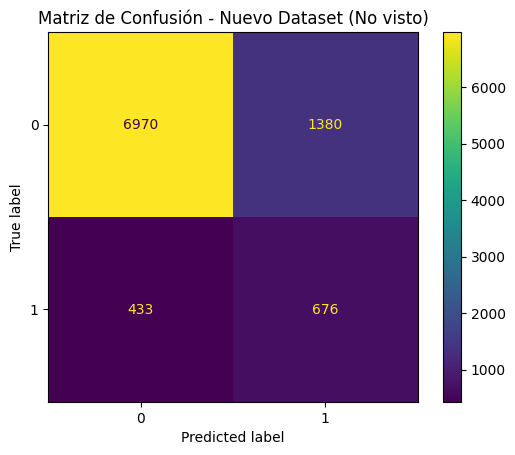

In [ ]:
#  MÉTRICAS FINALES EN DATOS NUEVOS
print("\n" + "="*70)
print("EVALUACIÓN EN NUEVO DATASET (NO VISTO)")
print("="*70)

acc_new = accuracy_score(y_new, y_pred_new)
prec_new = precision_score(y_new, y_pred_new, average="weighted", zero_division=0)
rec_new  = recall_score(y_new, y_pred_new, average="weighted", zero_division=0)
f1_new   = f1_score(y_new, y_pred_new, average="weighted", zero_division=0)

print(f"Modelo final: {final_model_name}")
print(f"Accuracy   (new): {acc_new:.4f}")
print(f"Precision  (new): {prec_new:.4f}")
print(f"Recall     (new): {rec_new:.4f}")
print(f"F1-Score   (new): {f1_new:.4f}")

if y_proba_new is not None:
    roc_new = roc_auc_score(y_new, y_proba_new)
    pr_new  = average_precision_score(y_new, y_proba_new)
    print(f"ROC-AUC    (new): {roc_new:.4f}")
    print(f"PR-AUC     (new): {pr_new:.4f}")

print("\nClassification report (new):")
print(classification_report(y_new, y_pred_new, zero_division=0))

print("\nMatriz de confusión (new):")
print(confusion_matrix(y_new, y_pred_new))

cm_new = confusion_matrix(y_new, y_pred_new)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_new)
disp.plot(values_format="d") 

plt.title("Matriz de Confusión - Nuevo Dataset (No visto)")
plt.grid(False)
plt.show()

In [ ]:

# COMPARACIÓN vs RESULTADOS DEL NOTEBOOK (TEST y CV)
print("\n" + "="*70)
print("COMPARACIÓN CONTRA RESULTADOS EXISTENTES (NOTEBOOK)")
print("="*70)

# TEST del notebook
row_final = df_results[df_results["Modelo"] == final_model_name].iloc[0]
print("== TEST (del notebook) vs NUEVO ==")
print(f"F1-Score (Test): {row_final['F1-Score (Test)']:.4f}  |  F1-Score (New): {f1_new:.4f}")
print(f"Recall   (Test): {row_final['Recall (Test)']:.4f}    |  Recall   (New): {rec_new:.4f}")
print(f"Prec.    (Test): {row_final['Precision (Test)']:.4f} |  Prec.    (New): {prec_new:.4f}")
print(f"Acc.     (Test): {row_final['Accuracy (Test)']:.4f}  |  Acc.     (New): {acc_new:.4f}")

# CV del notebook
if "cv_out" in globals():
    print("\n== CV en Train (del notebook) vs NUEVO ==")
    print(f"F1 (CV mean): {cv_out['test_f1'].mean():.4f} ± {cv_out['test_f1'].std():.4f}  |  F1 (New): {f1_new:.4f}")
    print(f"Recall (CV mean): {cv_out['test_recall'].mean():.4f} ± {cv_out['test_recall'].std():.4f}  |  Recall (New): {rec_new:.4f}")
    print(f"Prec. (CV mean): {cv_out['test_precision'].mean():.4f} ± {cv_out['test_precision'].std():.4f} |  Prec. (New): {prec_new:.4f}")
    print(f"Acc.  (CV mean): {cv_out['test_accuracy'].mean():.4f} ± {cv_out['test_accuracy'].std():.4f}  |  Acc.  (New): {acc_new:.4f}")
else:
    print("\nNota: 'cv_out' no existe")



COMPARACIÓN CONTRA RESULTADOS EXISTENTES (NOTEBOOK)
== TEST (del notebook) vs NUEVO ==
F1-Score (Test): 0.4659  |  F1-Score (New): 0.8312
Recall   (Test): 0.6199    |  Recall   (New): 0.8083
Prec.    (Test): 0.3732 |  Prec.    (New): 0.8697
Acc.     (Test): 0.8384  |  Acc.     (New): 0.8083

== CV en Train (del notebook) vs NUEVO ==
F1 (CV mean): 0.4481 ± 0.0108  |  F1 (New): 0.8312
Recall (CV mean): 0.5851 ± 0.0187  |  Recall (New): 0.8083
Prec. (CV mean): 0.3637 ± 0.0163 |  Prec. (New): 0.8697
Acc.  (CV mean): 0.8363 ± 0.0086  |  Acc.  (New): 0.8083


## Limitaciones del modelo para discusión


1) Sensibilidad a cambios de distribución (Data Drift):
   Si el perfil de los datos cambia en el tiempo, el modelo puede degradar su rendimiento.

2) Trade-off Precision vs Recall:
   El umbral por defecto (0.5) puede no ser óptimo según el costo de FN/FP.
   En contextos donde perder un positivo es muy caro, se debe ajustar el umbral.

3) Interpretabilidad:
   XGBoost es más complejo que modelos lineales.

4) Dependencia de calidad de datos:
   Valores faltantes, ruido, variables mal codificadas o categorías nuevas pueden afectar el desempeño
   (especialmente si el preprocesamiento no maneja unknown categories).

5) Generalización fuera del dominio:
   Si el dataset externo proviene de otra población/contexto, el desempeño puede variar notablemente.